<a href="https://colab.research.google.com/github/emmetorior/CN7030-/blob/main/TueNight_Multistock_Multifeature_Test_Classifier_from_original_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
!pip install pyspark pandas numpy

In [216]:
spark.catalog.clearCache()

from pyspark.sql import SparkSession
# Importing package
from pyspark.sql.functions import (
    expr, col, lag, lead, window, stddev, mean, first, last, concat, lit,
    when, abs, isnan, count, dayofmonth, month, year, to_date, udf, abs as spark_abs
)

import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
import pandas as pd
import numpy as np


In [217]:

####
def load_stock_data(data_dir, pd):
    stock_lookup = {
        "AAPL": "Apple Inc.",
        "NVDA": "NVIDIA Corp",
        "MSFT": "Microsoft",
        "AMZN": "Amazon",
        "QQQ" : "Invesco QQQ Trust",
        "AVGO": "Broadcom Inc.",
        "TSLA": "Tesla Inc.",
        "COST": "Costco Wholesale Corp",
        "NFLX": "Netflix Inc.",
        "GOOGL": "Alphabet Inc."
    }

    df_list = []
    for symbol, name in stock_lookup.items():
      file_path = f"{data_dir}/{symbol}.csv"
      try:
          #df = pd.read_csv(file_path, header=1)  # Skip the first line of each file as it's the header
          #df = pd.read_csv(file_path, usecols=[6])
          df = pd.read_csv(file_path)
          print(f"Loading: {symbol}")
          # new column at index 0 (the first col)
          df.insert(0, "symbol", symbol)
          df_list.append(df)
          combined_df = pd.concat(df_list, ignore_index=True)
          df.reset_index()
      except FileNotFoundError:
            print(f"Oops: {symbol} not found...")

    return combined_df

#

data_dir = "/content/drive/MyDrive/stockarchive/full_history"
df = load_stock_data(data_dir, pd)
df.head(34000)


Loading: AAPL
Loading: NVDA
Loading: MSFT
Loading: AMZN
Loading: QQQ
Loading: AVGO
Loading: TSLA
Loading: COST
Loading: NFLX
Loading: GOOGL


,symbol,date,volume,open,high,low,close,adjclose
0,AAPL,2020-07-02,28484300,367.850006,370.470001,363.640015,364.109985,364.109985
1,AAPL,2020-07-01,27684300,365.119995,367.359985,363.910004,364.109985,364.109985
2,AAPL,2020-06-30,35055800,360.079987,365.980011,360.000000,364.799988,364.799988
3,AAPL,2020-06-29,32661500,353.250000,362.170013,351.279999,361.779999,361.779999
4,AAPL,2020-06-26,51314200,364.410004,365.320007,353.019989,353.630005,353.630005
...,...,...,...,...,...,...,...,...
33995,TSLA,2014-10-13,11268700,238.570007,238.960007,221.000000,224.589996,224.589996
33996,TSLA,2014-10-10,12888300,244.639999,245.889999,235.199997,236.910004,236.910004
33997,TSLA,2014-10-09,7361300,262.250000,265.540009,254.399994,257.010010,257.010010
33998,TSLA,2014-10-08,5055100,260.100006,262.880005,252.639999,259.279999,259.279999


Clean the Data

In [218]:

####
def clean_data(df, pd):

    # fix from source how-to-remove-multiple-headers-row-in-a-pandas-data-frame StackOverflow Quang Hoang
    # Is this a problem? Maybe not.
   # df = df[df.ne(df.columns).any(1)]

    ## more pre cleaning later...
    df['date'] = pd.to_datetime(df['date'])
    #df.set_index('date', inplace=True)
    #df.index
    return df
clean_data(df, pd)


,symbol,date,volume,open,high,low,close,adjclose
0,AAPL,2020-07-02,28484300,367.850006,370.470001,363.640015,364.109985,364.109985
1,AAPL,2020-07-01,27684300,365.119995,367.359985,363.910004,364.109985,364.109985
2,AAPL,2020-06-30,35055800,360.079987,365.980011,360.000000,364.799988,364.799988
3,AAPL,2020-06-29,32661500,353.250000,362.170013,351.279999,361.779999,361.779999
4,AAPL,2020-06-26,51314200,364.410004,365.320007,353.019989,353.630005,353.630005
...,...,...,...,...,...,...,...,...
52176,GOOGL,2004-08-25,9188600,52.532532,54.054054,51.991993,53.053055,53.053055
52177,GOOGL,2004-08-24,15247300,55.675674,55.855854,51.836838,52.487488,52.487488
52178,GOOGL,2004-08-23,18256100,55.430431,56.796795,54.579578,54.754753,54.754753
52179,GOOGL,2004-08-20,22834300,50.555557,54.594593,50.300301,54.209209,54.209209


In [219]:
df_qqq = df.loc[ (df['symbol'] == 'QQQ') ]

df_qqq.head()

,symbol,date,volume,open,high,low,close,adjclose
24444,QQQ,2020-07-02,31898400,253.020004,254.270004,251.710007,252.190002,252.190002
24445,QQQ,2020-07-01,34689200,247.639999,251.520004,247.080002,250.490005,250.490005
24446,QQQ,2020-06-30,38909200,242.770004,248.160004,242.580002,247.600006,247.600006
24447,QQQ,2020-06-29,34377800,239.970001,242.850006,237.350006,242.839996,242.839996
24448,QQQ,2020-06-26,52824600,245.779999,245.960007,239.679993,240.220001,240.220001


Set up Spark, and the Spark dataframe is created from the pandas one.
Then we add some additional column data such as the 9 Day moving average, the trading range, and the percentage that the stock has changed since the previous day.

In [220]:
# Create Spark Session
spark = SparkSession.builder.appName("CN7030 Assn 1 - Stock Price Classifier").getOrCreate()

df_qqq = spark.createDataFrame(df_qqq)

In [221]:
# 2. Trading Range - daily price range for the stock
df_qqq = df_qqq.withColumn("Trading_Range", col("high") - col("low"))

In [222]:
# 3. Prev Close
df_qqq = df_qqq.withColumn("prev_close", lag("close").over(Window.orderBy("date")))

# 5. price_change_percentage
df_qqq = df_qqq.withColumn("price_change_percentage",
    (col("close") - col("prev_close")) / col("prev_close") * 100
)

In [252]:

windowSpec9Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-8, 0)
windowSpec100Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-99, 0)

# Calculate moving averages
df_qqq = df_qqq.withColumn("9_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec9Day))
df_qqq = df_qqq.withColumn("100_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec100Day))

# *row skipping solution from stackexchange
df_qqq = df_qqq.withColumn("row_id", F.row_number().over(Window.partitionBy("symbol").orderBy("date")))
df_qqq = df_qqq.filter(F.col("row_id") >= 100).drop("row_id")

# Show the result
#df_qqq_filtered.select("symbol", "date", "close", "9_Day_MA", "100_Day_MA").show(500)
#df_qqq = df_qqq[200:]

Clean up any null values and skip the first few days, since we are using moving averages.


In [228]:
# drop nulls
df_qqq = df_qqq.na.drop()

df_qqq.show()

+------+-------------------+--------+----------+---------+----------+---------+------------------+-------------+----------+-----------------------+------------------+------------------+------------------+
|symbol|               date|  volume|      open|     high|       low|    close|          adjclose|Trading_Range|prev_close|price_change_percentage|price_change_label|          9_Day_MA|        100_Day_MA|
+------+-------------------+--------+----------+---------+----------+---------+------------------+-------------+----------+-----------------------+------------------+------------------+------------------+
|   QQQ|1999-03-11 00:00:00| 9688600|   51.4375|51.734375|   50.3125|  51.3125|   44.741455078125|     1.421875|   51.0625|     0.4895960832313341|          UP-SMALL|           51.3125|           51.3125|
|   QQQ|1999-03-12 00:00:00| 8743600|    51.125| 51.15625|  49.65625|  50.0625| 43.65151977539063|          1.5|   51.3125|    -2.4360535931790497|        DOWN-LARGE|           50.

Populate the label column with values as follows:
Either Neutral, or Upward / Downward direction with a small, medium or large move, giving us NEUTRAL, DOWN_SMALL, DOWN_MEDIUM, DOWN_LARGE,  UP_SMALL, UP_MEDIUM, UP_LARGE

UP: +      DOWN: -
NEUTRAL: +- 0.3%
SMALL > 0.3% < 0.6
MEDIUM > 0.6% < 0.9%
LARGE > 0.9%

In [224]:
# Create label column derived from price change percentage and populate it
df_qqq = df_qqq.withColumn(
    "price_change_label", when(abs(col("price_change_percentage")) <= 0.3, "NEUTRAL")\
    .when((abs(col("price_change_percentage")) > 0.3) & (abs(col("price_change_percentage")) <= 0.6), "SMALL")\
    .when((abs(col("price_change_percentage")) > 0.6) & (abs(col("price_change_percentage")) <= 0.9), "MEDIUM")\
    .when(abs(col("price_change_percentage")) > 0.9, "LARGE")\
    .otherwise("NEUTRAL")  # Handle unexpected values
)

# Add "UP" or "DOWN" prefix based on the sign of price_change_percentage
df_qqq = df_qqq.withColumn(
    "price_change_label",
    when(col("price_change_percentage") > 0, concat(lit("UP-"), col("price_change_label")))
    .otherwise(concat(lit("DOWN-"), col("price_change_label")))
)

In [229]:

# Prepare features
#feature_columns = ['open', 'close', 'high', 'low', 'volume']
feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','100_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
prepared_df = assembler.transform(df_qqq)
prepared_df.show()

+------+-------------------+--------+----------+---------+----------+---------+------------------+-------------+----------+-----------------------+------------------+------------------+------------------+--------------------+
|symbol|               date|  volume|      open|     high|       low|    close|          adjclose|Trading_Range|prev_close|price_change_percentage|price_change_label|          9_Day_MA|        100_Day_MA|            features|
+------+-------------------+--------+----------+---------+----------+---------+------------------+-------------+----------+-----------------------+------------------+------------------+------------------+--------------------+
|   QQQ|1999-03-11 00:00:00| 9688600|   51.4375|51.734375|   50.3125|  51.3125|   44.741455078125|     1.421875|   51.0625|     0.4895960832313341|          UP-SMALL|           51.3125|           51.3125|[51.4375,51.3125,...|
|   QQQ|1999-03-12 00:00:00| 8743600|    51.125| 51.15625|  49.65625|  50.0625| 43.6515197753906

In [253]:


# Convert label column to numerical indexes
label_indexer = StringIndexer(
    inputCol='price_change_label',
    outputCol='indexlabel'
)

# Check if 'indexlabel' column already exists
if 'indexlabel' not in prepared_df.columns:
    prepared_df = label_indexer.fit(prepared_df).transform(prepared_df)
else:
    print("Column 'indexlabel' already exists. Skipping StringIndexer.")


In [254]:
# Split data
(train_data, test_data) = prepared_df.select('features', 'indexlabel').randomSplit([0.7, 0.3], seed=42)

# Train the Logistic Regression with max 10 iterations
lr = LogisticRegression(
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
    labelCol='indexlabel',  # Make sure labelCol matches the outputCol of StringIndexer
    featuresCol='features'
)
model = lr.fit(train_data)

In [255]:
# Evaluate the model
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol='indexlabel',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy = evaluator.evaluate(predictions)
print(f"Logistic Regression: Model Accuracy: {accuracy} ")
print(f"{int(np.round(accuracy * 100))}%")

Logistic Regression: Model Accuracy: 0.36807817589576547 
37%


In [256]:

# Prepare features again
# Prepare features
#feature_columns = ['open', 'close', 'high', 'low', 'volume']
feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','100_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
#We need to redefine the df again
prepared_df = assembler.transform(df_qqq)
prepared_df.show()
# Convert label column to numerical indexes (remains the same)
label_indexer2 = StringIndexer(
    inputCol='price_change_label',
    outputCol='indexlabel2'
)

# Check if 'indexlabel2' column already exists (remains the same)
if 'indexlabel2' not in prepared_df.columns:
    prepared_df = label_indexer2.fit(prepared_df).transform(prepared_df)
else:
    print("already exists. Skipping.")

# Split data (remains the same)
(train_data, test_data) = prepared_df.select('features', 'indexlabel2').randomSplit([0.7, 0.3], seed=42)

# Train the Decision Tree Classifier
dt = DecisionTreeClassifier(
      #7 zones - auto detected I think in this version. numClasses=7
    maxDepth=5,  # Hyperparameter - fix this
    impurity="gini",  # Impurity
    seed=42,  #
    labelCol='indexlabel2', # Changed to use 'indexlabel2' as the label column
    featuresCol='features'
)
model = dt.fit(train_data)

# Evaluate the model (remains the same)
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol='indexlabel2',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy = evaluator.evaluate(predictions)
print(f"Decision Tree: Model Accuracy: {accuracy} ")
print(f"{int(np.round(accuracy * 100))}%")

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------------+------------+-------+--------------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|price_change_label|          9_Day_MA|  100_Day_MA|row_num|            features|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------------+------------+-------+--------------------+
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.59375|  56.59375|   -0.27609055770292656|      DOWN-NEUTRAL| 57.11805555555556|54.419921875|    100|[56.6875,56.4375,...|
|   QQQ|1999-08-03 00:00:00|13005000|57.2109375|  57.21875|     55.25|56.0703125

EVALUATE THE LABELS

In [257]:
#Prepare Features again #3
# Prepare features
#feature_columns = ['open', 'close', 'high', 'low', 'volume']
feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
prepared_df = assembler.transform(df_qqq)
prepared_df.show()
#-
# Convert label column to numerical indexes
label_indexer = StringIndexer(
    inputCol='price_change_label',
    outputCol='label'
)

# Check if 'indexlabel3' column already exists
if 'label' not in prepared_df.columns:
    prepared_df = label_indexer.fit(prepared_df).transform(prepared_df)
else:
    print("Column 'label' already exists. Skipping StringIndexer.")
#-
# Split data
(train_data, test_data) = prepared_df.select('features', 'label').randomSplit([0.7, 0.3], seed=42)

#---------------------------------------------
# replace original columns here - like in the previous one. I just wrote this app with reduced features to make it easier to create.
prepared_df = prepared_df.withColumn('open', col('open')) \
    .withColumn('close', col('close')) \
    .withColumn('price_change_percentage', col('price_change_percentage'))
    #.withColumn('price_change_label', col('price_change_label'))

# Split into training and test sets
(train_data, test_data) = prepared_df.randomSplit([0.7, 0.3], seed=42)

# Training the log reg
lr = LogisticRegression(
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
    labelCol='label',
    featuresCol='features'
)
model = lr.fit(train_data)

# predict
predictions = model.transform(test_data)
predictions.select('prediction').show()

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------------+------------+-------+--------------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|price_change_label|          9_Day_MA|  100_Day_MA|row_num|            features|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------------+------------+-------+--------------------+
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.59375|  56.59375|   -0.27609055770292656|      DOWN-NEUTRAL| 57.11805555555556|54.419921875|    100|[56.6875,56.4375,...|
|   QQQ|1999-08-03 00:00:00|13005000|57.2109375|  57.21875|     55.25|56.0703125

In [258]:
# Define the mapping function
def map_prediction_to_label(prediction):
    temp = prediction
    pred = np.double(prediction)
    if (temp  < 0.3 ) and( temp >- 0.3):
      temp = "NEUTRAL"
    elif (temp>0.3):
      temp = "UP-"
    elif (temp<-0.3):
      temp = "DOWN-"

    tmpPred = np.abs(pred)

    if tmpPred < 0.3:
        tmpPredDesc = ''
    elif tmpPred < 0.6:
        tmpPredDesc = 'SMALL'
    elif tmpPred < 0.9:
        tmpPredDesc = 'MEDIUM'
    else:
        tmpPredDesc = 'LARGE'

    return temp + tmpPredDesc

# Register the function as a UDF
map_prediction_udf = udf(map_prediction_to_label, StringType())

# Use the UDF in the DataFrame
results_df = predictions.select(
    'open',
    'close',
    'price_change_percentage',
    'price_change_label',
    'prediction',
    map_prediction_udf(col('prediction')).alias('predicted_label')
)

# Display results
results_df.show()

+----------+----------+-----------------------+------------------+----------+---------------+
|      open|     close|price_change_percentage|price_change_label|prediction|predicted_label|
+----------+----------+-----------------------+------------------+----------+---------------+
|56.0703125|55.0546875|    -1.8113417862616692|        DOWN-LARGE|       1.0|       UP-LARGE|
|  54.46875|    54.125|    -0.9011586325275354|        DOWN-LARGE|       1.0|       UP-LARGE|
|    56.125|     55.25|    -1.1738401341531581|        DOWN-LARGE|       1.0|       UP-LARGE|
|  56.40625|  57.65625|      4.355203619909502|          UP-LARGE|       0.0|        NEUTRAL|
|  57.21875|   57.0625|    -1.1904761904761905|        DOWN-LARGE|       1.0|       UP-LARGE|
|    57.125|  57.96875|     1.5881708652792992|          UP-LARGE|       0.0|        NEUTRAL|
|      58.5|   59.8125|     3.1805929919137466|          UP-LARGE|       0.0|        NEUTRAL|
|60.9296875|    59.875|    -0.9947035266761401|        DOWN-

In [259]:
# Basic preprocessing

#Adjust cleaning threshold: If a significant number of closing prices are missing but some data remains valuable, you could adjust the dropna function. For example, instead of dropping all rows with missing values, you could specify a threshold (e.g., dropna(thresh=0.8)) to keep rows with at least 80% of the data points.
#stock_data.dropna(inplace=True)
#print(f"Stock data shape after cleaning: {stock_data.shape}")
# check if this dataframe is empty
#if not stock_data.empty:  # Check if DataFrame is not empty
  # Existing feature calculation code (e.g., Daily_Percent_Change)


#import pandas as pd
# data = yf.download(tickers='AAPL', period='5d', interval='5m')
# pd.set_option('display.max_rows', None)
# df = pd.DataFrame(data)

# Calculate features
#stock_data['MA20'] = stock_data['Close'].rolling(window=20).mean()
#stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
#Impute missing values: Consider filling missing values with a specific strategy like the mean, median, or a forward/backward fill approach. Pandas offers functions like fillna for this purpose.

# Skip the first 200 rows to avoid NaN values due to moving averages
#stock_data = stock_data.iloc[200:]

CLUSTERING

**Clustering workflow  (citation: workflow steps taken from google machine learning )
*   Prepare data.
*   Create Similarity Metric.
*   Run clustering algorithm.
*   Interpret results and adjust your clustering.
*   Run clustering algorithm.

Prepare data
As with any ML problem, you must normalize, scale, and transform feature data before training or fine-tuning a model on that data. In addition, before clustering, check that the prepared data lets you accurately calculate similarity between examples.

Review: For a review of data transformation, see Working with numerical data from Machine Learning Crash Course.
Create similarity metric
Before a clustering algorithm can group data, it needs to know how similar pairs of examples are. You can quantify the similarity between examples by creating a similarity metric, which requires a careful understanding of your data.

Run clustering algorithm
A clustering algorithm uses the similarity metric to cluster data. This course uses k-means.

Interpret results and adjust
Because clustering doesn't produce or include a ground "truth" against which you can verify the output, it's important to check the result against your expectations at both the cluster level and the example level. If the result looks odd or low-quality, experiment with the previous three steps. Continue iterating until the quality of the output meets your needs.

In [260]:
data_dir = "/content/drive/MyDrive/stockarchive/full_history"
df = load_stock_data(data_dir, pd)
df.head() #pandas df
print("")
df.info()

Loading: AAPL
Loading: NVDA
Loading: MSFT
Loading: AMZN
Loading: QQQ
Loading: AVGO
Loading: TSLA
Loading: COST
Loading: NFLX
Loading: GOOGL

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52181 entries, 0 to 52180
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   symbol    52181 non-null  object 
 1   date      52181 non-null  object 
 2   volume    52181 non-null  int64  
 3   open      52181 non-null  float64
 4   high      52181 non-null  float64
 5   low       52181 non-null  float64
 6   close     52181 non-null  float64
 7   adjclose  52181 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.2+ MB


In [238]:
#df["volume"].unique()

In [261]:

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()  # for plot styling

import pickle


In [262]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load
#stock_df = pd.read_csv("stock_data.csv")
data_dir = "/content/drive/MyDrive/stockarchive/full_history"
stock_df = load_stock_data(data_dir, pd)

# Ensure correct data types and inspect data
stock_df.info()

Loading: AAPL
Loading: NVDA
Loading: MSFT
Loading: AMZN
Loading: QQQ
Loading: AVGO
Loading: TSLA
Loading: COST
Loading: NFLX
Loading: GOOGL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52181 entries, 0 to 52180
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   symbol    52181 non-null  object 
 1   date      52181 non-null  object 
 2   volume    52181 non-null  int64  
 3   open      52181 non-null  float64
 4   high      52181 non-null  float64
 5   low       52181 non-null  float64
 6   close     52181 non-null  float64
 7   adjclose  52181 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.2+ MB


In [263]:

windowSpec9Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-8, 0)
windowSpec100Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-99, 0)

# Calculate moving averages
df_qqq = df_qqq.withColumn("9_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec9Day))
df_qqq = df_qqq.withColumn("100_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec100Day))

# *row skipping solution from stackexchange
df_qqq = df_qqq.withColumn("row_id", F.row_number().over(Window.partitionBy("symbol").orderBy("date")))
df_qqq = df_qqq.filter(F.col("row_id") >= 100).drop("row_id")

In [264]:
# Calculate 'price_change_percentage' before using it for clustering
# Assuming 'close' is the closing price column
stock_df['price_change_percentage'] = stock_df['close'].pct_change() * 100

# Drop missing values if any, including those introduced by pct_change
stock_data = stock_df[["close", "volume", "price_change_percentage"]].dropna()


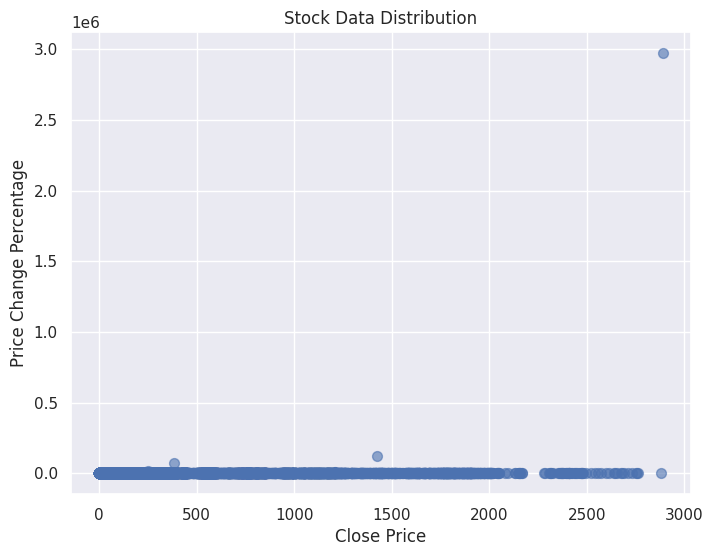

Cluster Counts: {0: 35501, 1: 2973, 2: 450, 3: 13256}


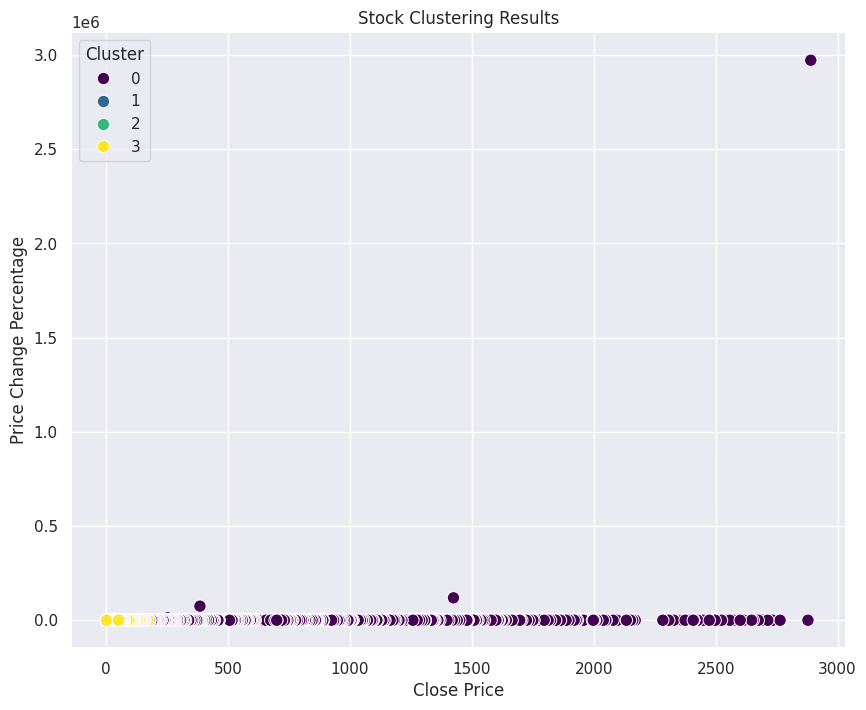

In [265]:


# Visualize initial data distribution
plt.figure(figsize=(8, 6))
plt.scatter(stock_data["close"], stock_data["price_change_percentage"], s=50, alpha=0.6)
plt.title("Stock Data Distribution")
plt.xlabel("Close Price")
plt.ylabel("Price Change Percentage")
plt.show()

# Drop missing values if any
#stock_data = stock_df[["close", "volume", "price_change_percentage"]].dropna()

# Train a KMeans model
model = KMeans(n_clusters=4, random_state=42)
model.fit(stock_data)

# Save the model to a pickle file
pickle_filename = "kmeans_stock_model.pickle"
pickle.dump(model, open(pickle_filename, "wb"))

# Load the model from the pickle file
loaded_model = pickle.load(open(pickle_filename, "rb"))

# Get cluster labels
labels = loaded_model.labels_

# Count number of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)
print("Cluster Counts:", dict(zip(unique_labels, label_counts)))

# Add labels to DataFrame
stock_data["Cluster"] = labels

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=stock_data["close"],
    y=stock_data["price_change_percentage"],
    hue=stock_data["Cluster"],
    palette="viridis", s=80
)
plt.title("Stock Clustering Results")
plt.xlabel("Close Price")
plt.ylabel("Price Change Percentage")
plt.show()
